# Projektas

## Modulių importavimas ir bendros parinktys

In [1]:
from pyspark import ml
from pyspark import mllib
from pyspark.mllib.stat import Statistics
import pyspark.ml.feature
import pyspark.ml.clustering
import pyspark.ml.classification
import pyspark.ml.evaluation
import pyspark.mllib.feature
import pyspark.mllib.clustering
import ggplot as gg
import pandas as pd
import os

import numpy as np

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.mllib.linalg import DenseVector, Vectors

def ensureDenseFeatures(featurizedDF, featuresCol="features"):
    columns = featurizedDF.columns
    idxCol = columns.index(featuresCol)
    transformedRow = pyspark.sql.Row(*columns)
    
    def rowColumnSparseToDense(row):
        values = list(row)
        values[idxCol] = pyspark.mllib.linalg.DenseVector(row[idxCol].toArray())
        return transformedRow(*values)
    
    featurizedDF = featurizedDF.rdd.map(rowColumnSparseToDense).toDF()
    
    return featurizedDF

def predictKMeans(x, centers):
    return min(
        (i for i in range(len(centers))), 
        key=lambda i: (x - centers[i]).norm(2))

def addKMeansPredictionToRow(row, featuresCol, kMeansModelCenters):
    features = row.asDict()[featuresCol]
    return row + (predictKMeans(features, kMeansModelCenters),)

def addKMeansPredictionToDataFrame(df, featuresCol, predictionCol, kMeansModelCenters):
    return (
        df.rdd
        .map(lambda r: addKMeansPredictionToRow(r, featuresCol, kMeansModelCenters))
        .toDF(df.columns + [predictionCol])
    )

Grafikų braižymui notebook'e:

In [2]:
%matplotlib inline

## Duomenų įkėlimas

Patikriname ar `pySpark` branduoklys sėkmingai įkeltas, t.y. ar aplinkoje egzistuoja `sqlContext` objektas:

In [3]:
sqlContext

Mūsų darbinė direktorija:

In [4]:
! pwd

/home/vagrant/synced_dir


In [5]:
! tree -L 2

.
├── 00015
│   ├── customer_churners_00015.csv
│   └── customer_usage_00015.csv
├── 00024
│   ├── customer_churners_00024.csv
│   └── customer_usage_00024.csv
├── aggregation (2).ipynb
├── Arnoldo
│   ├── Data
│   ├── Notebooks
│   ├── Output
│   └── README.md
├── bank_minimal_example.ipynb
├── derby.log
├── hs_err_pid2455.log
├── hs_err_pid3133.log
├── hs_err_pid8386.log
├── hs_err_pid8672.log
├── hs_err_pid9067.log
├── hs_err_pid9237.log
├── hs_err_pid9513.log
├── Klasterizavimas.ipynb
├── metastore_db
│   ├── db.lck
│   ├── log
│   ├── README_DO_NOT_TOUCH_FILES.txt
│   ├── seg0
│   ├── service.properties
│   └── tmp
├── Projektas-Copy1.ipynb
├── Projektas-Copy2.ipynb
├── Projektas.ipynb
├── README.md
├── Untitled1.ipynb
└── Untitled.ipynb

10 directories, 25 files


Prieš įkeliant duomenis patikriname jų formatą.

In [6]:
! head -n 2 00024/customer_usage_00024.csv

year,month,user_account_id,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,reloads_inactive_days,reloads_count,reloads_sum,calls_outgoing_count,calls_outgoing_spendings,calls_outgoing_duration,calls_outgoing_spendings_max,calls_outgoing_duration_max,calls_outgoing_inactive_days,calls_outgoing_to_onnet_count,calls_outgoing_to_onnet_spendings,calls_outgoing_to_onnet_duration,calls_outgoing_to_onnet_inactive_days,calls_outgoing_to_offnet_count,calls_outgoing_to_offnet_spendings,calls_outgoing_to_offnet_duration,calls_outgoing_to_offnet_inactive_days,calls_outgoing_to_abroad_count,calls_outgoing_to_abroad_spendings,calls_outgoing_to_abroad_duration,calls_outgoing_to_abroad_inactive_days,sms_outgoing_count,sms_outgoing_spendings,sms_outgoing_spendings_max,sms_outgoing_inactive_days,sms_outgoing_to_onnet_count,sms_outgoing_to_onnet_spendings,sms_outgoing_to_onnet_

In [50]:
! head -n 2 00024/customer_churners_00024.csv

year,month,user_account_id,churn
2016,9,376265,0


Duomenų nuskaitymas naudojant spark-csv Apache Spark

In [7]:
pathDataset = '00024/customer_usage_00024.csv'

bankDf = (
    sqlContext.read.format('com.databricks.spark.csv')
    .options(header='true', inferschema='true', delimiter=",")
    .load(pathDataset)
)


In [51]:
pathDataset = '00024/customer_churners_00024.csv'

churnersDf = (
    sqlContext.read.format('com.databricks.spark.csv')
    .options(header='true', inferschema='true', delimiter=",")
    .load(pathDataset)
)

In [8]:
bankDf.columns

['year',
 'month',
 'user_account_id',
 'user_lifetime',
 'user_intake',
 'user_no_outgoing_activity_in_days',
 'user_account_balance_last',
 'user_spendings',
 'user_has_outgoing_calls',
 'user_has_outgoing_sms',
 'user_use_gprs',
 'user_does_reload',
 'reloads_inactive_days',
 'reloads_count',
 'reloads_sum',
 'calls_outgoing_count',
 'calls_outgoing_spendings',
 'calls_outgoing_duration',
 'calls_outgoing_spendings_max',
 'calls_outgoing_duration_max',
 'calls_outgoing_inactive_days',
 'calls_outgoing_to_onnet_count',
 'calls_outgoing_to_onnet_spendings',
 'calls_outgoing_to_onnet_duration',
 'calls_outgoing_to_onnet_inactive_days',
 'calls_outgoing_to_offnet_count',
 'calls_outgoing_to_offnet_spendings',
 'calls_outgoing_to_offnet_duration',
 'calls_outgoing_to_offnet_inactive_days',
 'calls_outgoing_to_abroad_count',
 'calls_outgoing_to_abroad_spendings',
 'calls_outgoing_to_abroad_duration',
 'calls_outgoing_to_abroad_inactive_days',
 'sms_outgoing_count',
 'sms_outgoing_spending

In [52]:
churnersDf.columns

['year', 'month', 'user_account_id', 'churn']

In [9]:
summaryDf = bankDf.describe()
summaryDf

DataFrame[summary: string, year: string, month: string, user_account_id: string, user_lifetime: string, user_intake: string, user_no_outgoing_activity_in_days: string, user_account_balance_last: string, user_spendings: string, user_has_outgoing_calls: string, user_has_outgoing_sms: string, user_use_gprs: string, user_does_reload: string, reloads_inactive_days: string, reloads_count: string, reloads_sum: string, calls_outgoing_count: string, calls_outgoing_spendings: string, calls_outgoing_duration: string, calls_outgoing_spendings_max: string, calls_outgoing_duration_max: string, calls_outgoing_inactive_days: string, calls_outgoing_to_onnet_count: string, calls_outgoing_to_onnet_spendings: string, calls_outgoing_to_onnet_duration: string, calls_outgoing_to_onnet_inactive_days: string, calls_outgoing_to_offnet_count: string, calls_outgoing_to_offnet_spendings: string, calls_outgoing_to_offnet_duration: string, calls_outgoing_to_offnet_inactive_days: string, calls_outgoing_to_abroad_coun

In [53]:
churnersSummaryDf = churnersDf.describe()
churnersSummaryDf

DataFrame[summary: string, year: string, month: string, user_account_id: string, churn: string]

In [10]:
summaryDf.toPandas().T

0                     1  \
summary                                      count                  mean   
year                                        118358                2016.0   
month                                       118358     7.048826441812129   
user_account_id                             118358     539949.7984842596   
user_lifetime                               118358     2825.428690920766   
user_intake                                 118358    0.0254989100863482   
user_no_outgoing_activity_in_days           118358     44.89034961726288   
user_account_balance_last                   118358    10.512287213369797   
user_spendings                              118358     7.134741124385283   
user_has_outgoing_calls                     118358     0.882897649504047   
user_has_outgoing_sms                       118358    0.6560604268406023   
user_use_gprs                               118358   0.05063451562209568   
user_does_reload                            118358   0.49138207810202944   
reloads_inactive_days                       118358     398.9339377143919   
reloads_count                               118358    0.8578042886834857   
reloads_sum                                 118358     7.528104310651469   
calls_outgoing_count                        118358     36.87045235641021   
calls_outgoing_spendings                    118358     4.914706483718775   
calls_outgoing_duration                     118358     33.29619924297494   
calls_outgoing_spendings_max                118358     0.921794808969484   
calls_outgoing_duration_max                 118358     5.054475574105678   
calls_outgoing_inactive_days                118358    100.78173845451934   
calls_outgoing_to_onnet_count               118358   0.49275080687406003   
calls_outgoing_to_onnet_spendings           118358    0.2070551209043738   
calls_outgoing_to_onnet_duration            118358     0.619416769462141   
calls_outgoing_to_onnet_inactive_days       118358    100.78173845451934   
calls_outgoing_to_offnet_count              118358    16.149453353385493   
calls_outgoing_to_offnet_spendings          118358    2.9243267882186372   
calls_outgoing_to_offnet_duration           118358     21.26665396508895   
calls_outgoing_to_offnet_inactive_days      118358    100.78173845451934   
...                                            ...                   ...   
sms_outgoing_spendings_max                  118358   0.09312653137094988   
sms_outgoing_inactive_days                  118358    334.80831882931443   
sms_outgoing_to_onnet_count                 118358     2.737347707801754   
sms_outgoing_to_onnet_spendings             118358   0.12185741563730748   
sms_outgoing_to_onnet_inactive_days         118358    334.80831882931443   
sms_outgoing_to_offnet_count                118358      22.7918518393349   
sms_outgoing_to_offnet_spendings            118358     1.330439598506164   
sms_outgoing_to_offnet_inactive_days        118358    334.80831882931443   
sms_outgoing_to_abroad_count                118358    1.8350005914260126   
sms_outgoing_to_abroad_spendings            118358   0.19573480457595532   
sms_outgoing_to_abroad_inactive_days        118358    334.80831882931443   
sms_incoming_count                          118358     9.556278409570963   
sms_incoming_spendings                      118358   0.13639399111171527   
sms_incoming_from_abroad_count              118358    1.4011051217492692   
sms_incoming_from_abroad_spendings          118358  0.013884317071934228   
gprs_session_count                          118358     10.31874482502239   
gprs_usage                                  118358     3.152055374372663   
gprs_spendings                              118358   0.20893154666351169   
gprs_inactive_days                          118358    1199.0838557596444   
last_100_reloads_count                      118358     3.693692019128407   
last_100_reloads_sum                        118358     23.36222410314434   
last_100_calls_outgoi

In [54]:
churnersSummaryDf.toPandas().T

0                   1                       2     3  \
summary          count                mean                  stddev   min   
year             43179              2016.0  1.1368669192248387E-13  2016   
month            43179                 9.0                     0.0     9   
user_account_id  43179   596044.4772922022         429228.37556463    18   
churn            43179  0.2096852636698395      0.4070886781451279     0   

                       4  
summary              max  
year                2016  
month                  9  
user_account_id  1196944  
churn                  1

## AGREGAVIMAS

In [11]:
bankDf.registerTempTable("customer_usage")

In [12]:
dateCols = ["year", "month"]
idCols = ["user_account_id"]
binaryCols = [
    "user_intake",
    "user_has_outgoing_calls", "user_has_outgoing_sms", 
    "user_use_gprs", "user_does_reload"
]

In [13]:
categoricalCols = dateCols + binaryCols + idCols

continuousCols = [c for c in bankDf.columns if c not in categoricalCols]

In [14]:
sqlExprsMeanCols = ["AVG({0}) AS {0}".format(c) for c in continuousCols]
sqlExprsMeanCols

['AVG(user_lifetime) AS user_lifetime',
 'AVG(user_no_outgoing_activity_in_days) AS user_no_outgoing_activity_in_days',
 'AVG(user_account_balance_last) AS user_account_balance_last',
 'AVG(user_spendings) AS user_spendings',
 'AVG(reloads_inactive_days) AS reloads_inactive_days',
 'AVG(reloads_count) AS reloads_count',
 'AVG(reloads_sum) AS reloads_sum',
 'AVG(calls_outgoing_count) AS calls_outgoing_count',
 'AVG(calls_outgoing_spendings) AS calls_outgoing_spendings',
 'AVG(calls_outgoing_duration) AS calls_outgoing_duration',
 'AVG(calls_outgoing_spendings_max) AS calls_outgoing_spendings_max',
 'AVG(calls_outgoing_duration_max) AS calls_outgoing_duration_max',
 'AVG(calls_outgoing_inactive_days) AS calls_outgoing_inactive_days',
 'AVG(calls_outgoing_to_onnet_count) AS calls_outgoing_to_onnet_count',
 'AVG(calls_outgoing_to_onnet_spendings) AS calls_outgoing_to_onnet_spendings',
 'AVG(calls_outgoing_to_onnet_duration) AS calls_outgoing_to_onnet_duration',
 'AVG(calls_outgoing_to_onne

In [15]:
sqlExprsBinaryCols = ["MAX({0}) AS {0}".format(c) for c in binaryCols]
sqlExprsBinaryCols

['MAX(user_intake) AS user_intake',
 'MAX(user_has_outgoing_calls) AS user_has_outgoing_calls',
 'MAX(user_has_outgoing_sms) AS user_has_outgoing_sms',
 'MAX(user_use_gprs) AS user_use_gprs',
 'MAX(user_does_reload) AS user_does_reload']

In [16]:
sqlExprsDateCols = ["COUNT(*) AS n_months"]
sqlExprsDateCols

['COUNT(*) AS n_months']

In [17]:
sqlSelectExprs = sqlExprsMeanCols + sqlExprsBinaryCols + sqlExprsDateCols
sqlSelectExprs

['AVG(user_lifetime) AS user_lifetime',
 'AVG(user_no_outgoing_activity_in_days) AS user_no_outgoing_activity_in_days',
 'AVG(user_account_balance_last) AS user_account_balance_last',
 'AVG(user_spendings) AS user_spendings',
 'AVG(reloads_inactive_days) AS reloads_inactive_days',
 'AVG(reloads_count) AS reloads_count',
 'AVG(reloads_sum) AS reloads_sum',
 'AVG(calls_outgoing_count) AS calls_outgoing_count',
 'AVG(calls_outgoing_spendings) AS calls_outgoing_spendings',
 'AVG(calls_outgoing_duration) AS calls_outgoing_duration',
 'AVG(calls_outgoing_spendings_max) AS calls_outgoing_spendings_max',
 'AVG(calls_outgoing_duration_max) AS calls_outgoing_duration_max',
 'AVG(calls_outgoing_inactive_days) AS calls_outgoing_inactive_days',
 'AVG(calls_outgoing_to_onnet_count) AS calls_outgoing_to_onnet_count',
 'AVG(calls_outgoing_to_onnet_spendings) AS calls_outgoing_to_onnet_spendings',
 'AVG(calls_outgoing_to_onnet_duration) AS calls_outgoing_to_onnet_duration',
 'AVG(calls_outgoing_to_onne

In [18]:
sqlSelect = ", ".join(sqlSelectExprs)
sqlSelect

'AVG(user_lifetime) AS user_lifetime, AVG(user_no_outgoing_activity_in_days) AS user_no_outgoing_activity_in_days, AVG(user_account_balance_last) AS user_account_balance_last, AVG(user_spendings) AS user_spendings, AVG(reloads_inactive_days) AS reloads_inactive_days, AVG(reloads_count) AS reloads_count, AVG(reloads_sum) AS reloads_sum, AVG(calls_outgoing_count) AS calls_outgoing_count, AVG(calls_outgoing_spendings) AS calls_outgoing_spendings, AVG(calls_outgoing_duration) AS calls_outgoing_duration, AVG(calls_outgoing_spendings_max) AS calls_outgoing_spendings_max, AVG(calls_outgoing_duration_max) AS calls_outgoing_duration_max, AVG(calls_outgoing_inactive_days) AS calls_outgoing_inactive_days, AVG(calls_outgoing_to_onnet_count) AS calls_outgoing_to_onnet_count, AVG(calls_outgoing_to_onnet_spendings) AS calls_outgoing_to_onnet_spendings, AVG(calls_outgoing_to_onnet_duration) AS calls_outgoing_to_onnet_duration, AVG(calls_outgoing_to_onnet_inactive_days) AS calls_outgoing_to_onnet_inact

In [19]:
aggregatedUsageDf = sqlContext.sql("""
    SELECT user_account_id, {}
    FROM customer_usage
    GROUP BY user_account_id
""".format(sqlSelect))

In [20]:
aggregatedUsageDf.first()

Row(user_account_id=1031, user_lifetime=947.0, user_no_outgoing_activity_in_days=0.3333333333333333, user_account_balance_last=10.993333333333334, user_spendings=10.3, reloads_inactive_days=12.0, reloads_count=1.3333333333333333, reloads_sum=10.013333333333334, calls_outgoing_count=83.66666666666667, calls_outgoing_spendings=5.859999999999999, calls_outgoing_duration=55.69, calls_outgoing_spendings_max=0.5966666666666667, calls_outgoing_duration_max=10.333333333333334, calls_outgoing_inactive_days=0.6666666666666666, calls_outgoing_to_onnet_count=0.0, calls_outgoing_to_onnet_spendings=0.0, calls_outgoing_to_onnet_duration=0.0, calls_outgoing_to_onnet_inactive_days=0.6666666666666666, calls_outgoing_to_offnet_count=23.333333333333332, calls_outgoing_to_offnet_spendings=2.8833333333333333, calls_outgoing_to_offnet_duration=25.0, calls_outgoing_to_offnet_inactive_days=0.6666666666666666, calls_outgoing_to_abroad_count=0.0, calls_outgoing_to_abroad_spendings=0.0, calls_outgoing_to_abroad_d

## Požymių (angl. _features_) sudarymas klasterizavimui

In [21]:
assembler = VectorAssembler(inputCols=continuousCols, outputCol="features")

In [22]:
featurizedDF = assembler.transform(aggregatedUsageDf)

In [23]:
scaler = StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")

In [75]:
featuresEnsuredDF = ensureDenseFeatures(featurizedDF)

In [76]:
featuresEnsuredDF.first()

Row(user_account_id=1031, user_lifetime=947.0, user_no_outgoing_activity_in_days=0.3333333333333333, user_account_balance_last=10.993333333333334, user_spendings=10.3, reloads_inactive_days=12.0, reloads_count=1.3333333333333333, reloads_sum=10.013333333333334, calls_outgoing_count=83.66666666666667, calls_outgoing_spendings=5.859999999999999, calls_outgoing_duration=55.69, calls_outgoing_spendings_max=0.5966666666666667, calls_outgoing_duration_max=10.333333333333334, calls_outgoing_inactive_days=0.6666666666666666, calls_outgoing_to_onnet_count=0.0, calls_outgoing_to_onnet_spendings=0.0, calls_outgoing_to_onnet_duration=0.0, calls_outgoing_to_onnet_inactive_days=0.6666666666666666, calls_outgoing_to_offnet_count=23.333333333333332, calls_outgoing_to_offnet_spendings=2.8833333333333333, calls_outgoing_to_offnet_duration=25.0, calls_outgoing_to_offnet_inactive_days=0.6666666666666666, calls_outgoing_to_abroad_count=0.0, calls_outgoing_to_abroad_spendings=0.0, calls_outgoing_to_abroad_d

In [26]:
scalerModelEnsured = scaler.fit(featuresEnsuredDF)

In [27]:
featurizedScaledEnsuredDF = scalerModelEnsured.transform(featuresEnsuredDF)

In [28]:
featurizedScaledEnsuredDF.take(5)

[Row(user_account_id=1031, user_lifetime=947.0, user_no_outgoing_activity_in_days=0.3333333333333333, user_account_balance_last=10.993333333333334, user_spendings=10.3, reloads_inactive_days=12.0, reloads_count=1.3333333333333333, reloads_sum=10.013333333333334, calls_outgoing_count=83.66666666666667, calls_outgoing_spendings=5.859999999999999, calls_outgoing_duration=55.69, calls_outgoing_spendings_max=0.5966666666666667, calls_outgoing_duration_max=10.333333333333334, calls_outgoing_inactive_days=0.6666666666666666, calls_outgoing_to_onnet_count=0.0, calls_outgoing_to_onnet_spendings=0.0, calls_outgoing_to_onnet_duration=0.0, calls_outgoing_to_onnet_inactive_days=0.6666666666666666, calls_outgoing_to_offnet_count=23.333333333333332, calls_outgoing_to_offnet_spendings=2.8833333333333333, calls_outgoing_to_offnet_duration=25.0, calls_outgoing_to_offnet_inactive_days=0.6666666666666666, calls_outgoing_to_abroad_count=0.0, calls_outgoing_to_abroad_spendings=0.0, calls_outgoing_to_abroad_

In [29]:
featurizedScaledEnsuredDF.columns

['user_account_id',
 'user_lifetime',
 'user_no_outgoing_activity_in_days',
 'user_account_balance_last',
 'user_spendings',
 'reloads_inactive_days',
 'reloads_count',
 'reloads_sum',
 'calls_outgoing_count',
 'calls_outgoing_spendings',
 'calls_outgoing_duration',
 'calls_outgoing_spendings_max',
 'calls_outgoing_duration_max',
 'calls_outgoing_inactive_days',
 'calls_outgoing_to_onnet_count',
 'calls_outgoing_to_onnet_spendings',
 'calls_outgoing_to_onnet_duration',
 'calls_outgoing_to_onnet_inactive_days',
 'calls_outgoing_to_offnet_count',
 'calls_outgoing_to_offnet_spendings',
 'calls_outgoing_to_offnet_duration',
 'calls_outgoing_to_offnet_inactive_days',
 'calls_outgoing_to_abroad_count',
 'calls_outgoing_to_abroad_spendings',
 'calls_outgoing_to_abroad_duration',
 'calls_outgoing_to_abroad_inactive_days',
 'sms_outgoing_count',
 'sms_outgoing_spendings',
 'sms_outgoing_spendings_max',
 'sms_outgoing_inactive_days',
 'sms_outgoing_to_onnet_count',
 'sms_outgoing_to_onnet_spendi

## Klasterizavimas

### K-vidurkių modelis naudojant `pyspark.mllib.clustering.KMeans`

`pyspark.mllib` naudojami `RDD`, o ne `DataFrame` objektai, todėl sukuriame normalizuotų požymių `RDD`:

In [30]:
scaledFeaturesRdd = (
    featurizedScaledEnsuredDF.select("scaled_features").rdd 
    .map(lambda r: r[0])
)

Sudarome modelį su klasterių skaičiumi `k`:

In [31]:
k = 5
kmeansModelMllib = mllib.clustering.KMeans.train(scaledFeaturesRdd, k=k)

In [32]:
kmeansModelMllib.centers

[array([-0.43586261, -0.22128421,  0.11788879, -0.10531157, -0.10776083,
        -0.15249682, -0.10010392, -0.07518552, -0.12552984, -0.12034445,
        -0.01266216,  0.02282665, -0.39229245, -0.02754025, -0.04324617,
        -0.04290307, -0.39229245, -0.07844675, -0.10902821, -0.11054794,
        -0.39229245, -0.01197888, -0.04331378, -0.03947848, -0.39229245,
        -0.03657873, -0.01606109,  0.09538607, -0.5843755 ,  0.00315102,
         0.02767195, -0.5843755 , -0.01786902, -0.01488583, -0.5843755 ,
         0.00523802,  0.0044773 , -0.5843755 ,  0.08447428,  0.0026971 ,
         0.1117457 ,  0.02427073, -0.01602656, -0.01663786, -0.01266009,
        -0.06613963, -0.09834572, -0.08501949, -0.11277845, -0.03755379,
        -0.10677459, -0.03460668, -0.02865105,  0.01162118, -0.00850179,
         0.00746218, -0.01831056]),
 array([ 1.10771698,  0.55928634, -0.35995998, -0.50520811,  0.48332307,
        -0.33639244, -0.49382798, -0.50466634, -0.44826314, -0.47889374,
        -0.5250

In [33]:
mllibKmeansClusteredBankDf = addKMeansPredictionToDataFrame(
    featurizedScaledEnsuredDF, 
    "scaled_features", 
    "pred_kmeans_mllib", 
    kmeansModelMllib.centers)

In [34]:
ks = list(range(1, 10))

In [35]:
kMllibModelPairs = [
    (k, mllib.clustering.KMeans.train(scaledFeaturesRdd, k=k)) 
    for k in ks
]

In [36]:
kMllibCostPairs = [
    (k, model.computeCost(scaledFeaturesRdd)) 
    for k, model in kMllibModelPairs
]

In [37]:
kMllibCostPdDf = pd.DataFrame.from_records(
    kMllibCostPairs, 
    columns=["k", "cost"])

/home/vagrant/.miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


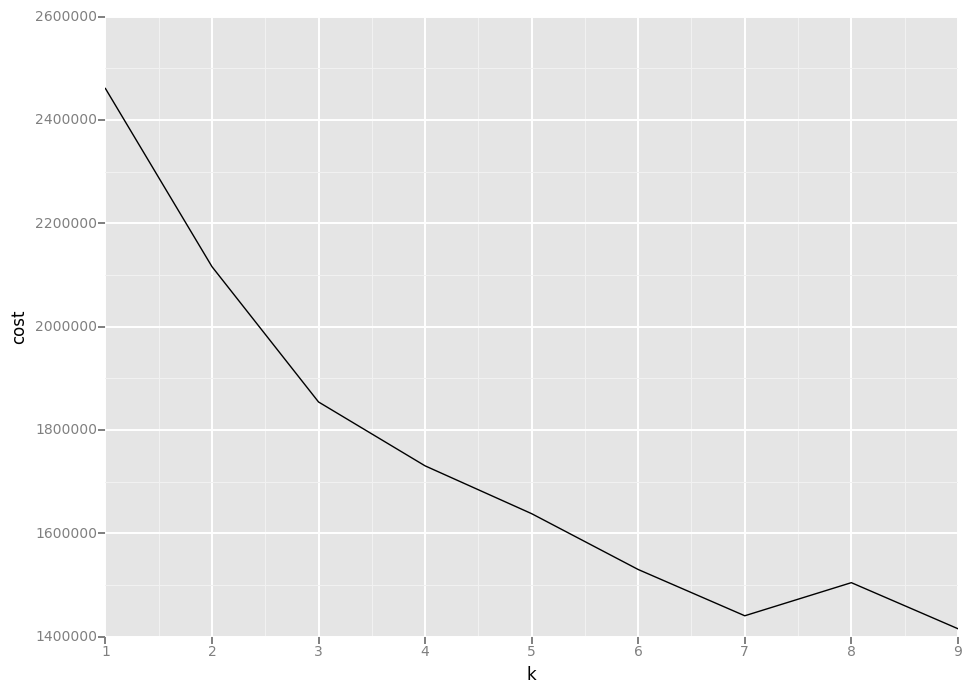

<ggplot: (-899507446)>

In [38]:
gg.ggplot(kMllibCostPdDf, gg.aes(x="k", y="cost")) + gg.geom_line()

## Klasifikavimas

### Apmokymo, validavimo ir testavimo imčių sudarymas ir požymių (angl. _features_) sudarymas klasifikavimui

Naudosime sprendimų medžio modelį, kuriam kintamųjų normalizuoti nebūtina ir kuriam tinka ne tik tolydžiojo tipo kintamieji.

In [99]:
responseColumns = ["churn"]

In [100]:
featuresEnsuredDF.registerTempTable("featuresEnsured")
churnersDf.registerTempTable("churners")

In [101]:
clasificationDf = sqlContext.sql("""
    SELECT a.*, b.churn
    FROM customer_usage a, churners b
    WHERE a.user_account_id = b.user_account_id
""")

clasificationDf.first()

Row(year=2016, month=6, user_account_id=1031, user_lifetime=916, user_intake=0, user_no_outgoing_activity_in_days=1, user_account_balance_last=9.81, user_spendings=10.83, user_has_outgoing_calls=1, user_has_outgoing_sms=1, user_use_gprs=0, user_does_reload=1, reloads_inactive_days=13, reloads_count=1, reloads_sum=6.0, calls_outgoing_count=65, calls_outgoing_spendings=6.03, calls_outgoing_duration=52.93, calls_outgoing_spendings_max=0.57, calls_outgoing_duration_max=9.0, calls_outgoing_inactive_days=1, calls_outgoing_to_onnet_count=0, calls_outgoing_to_onnet_spendings=0.0, calls_outgoing_to_onnet_duration=0.0, calls_outgoing_to_onnet_inactive_days=1, calls_outgoing_to_offnet_count=20, calls_outgoing_to_offnet_spendings=3.12, calls_outgoing_to_offnet_duration=26.0, calls_outgoing_to_offnet_inactive_days=1, calls_outgoing_to_abroad_count=0, calls_outgoing_to_abroad_spendings=0.0, calls_outgoing_to_abroad_duration=0.0, calls_outgoing_to_abroad_inactive_days=1, sms_outgoing_count=98, sms_ou

In [102]:
indexingStages = ([ml.feature.StringIndexer(inputCol="churn", outputCol="label_index")])

indexingStages

[StringIndexer_4e1dadada545f28a1ccb]

In [103]:
indexingPipeline = ml.pipeline.Pipeline(stages=indexingStages)

In [104]:
classificationFeatureColumns = [c for c in clasificationDf.columns if c not in (responseColumns)]
classificationFeatureColumns

['year',
 'month',
 'user_account_id',
 'user_lifetime',
 'user_intake',
 'user_no_outgoing_activity_in_days',
 'user_account_balance_last',
 'user_spendings',
 'user_has_outgoing_calls',
 'user_has_outgoing_sms',
 'user_use_gprs',
 'user_does_reload',
 'reloads_inactive_days',
 'reloads_count',
 'reloads_sum',
 'calls_outgoing_count',
 'calls_outgoing_spendings',
 'calls_outgoing_duration',
 'calls_outgoing_spendings_max',
 'calls_outgoing_duration_max',
 'calls_outgoing_inactive_days',
 'calls_outgoing_to_onnet_count',
 'calls_outgoing_to_onnet_spendings',
 'calls_outgoing_to_onnet_duration',
 'calls_outgoing_to_onnet_inactive_days',
 'calls_outgoing_to_offnet_count',
 'calls_outgoing_to_offnet_spendings',
 'calls_outgoing_to_offnet_duration',
 'calls_outgoing_to_offnet_inactive_days',
 'calls_outgoing_to_abroad_count',
 'calls_outgoing_to_abroad_spendings',
 'calls_outgoing_to_abroad_duration',
 'calls_outgoing_to_abroad_inactive_days',
 'sms_outgoing_count',
 'sms_outgoing_spending

In [105]:
classificationAssembler = ml.feature.VectorAssembler(inputCols=classificationFeatureColumns, outputCol="features")

In [106]:
classificationFeaturizationPipeline = ml.pipeline.Pipeline(stages=[indexingPipeline, classificationAssembler])

In [107]:
classificationFeaturizationPipelineModel = classificationFeaturizationPipeline.fit(clasificationDf)

In [108]:
featurizedClassificationBankDf = classificationFeaturizationPipelineModel.transform(clasificationDf)

In [109]:
featurizedClassificationBankDf.select(["churn", "label_index"]).take(10)

[Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0)]

Kintamojo reikšmė ir indeksas sutampa.

In [110]:
trainingDf, validationDf, testDf = featurizedClassificationBankDf.randomSplit([0.5, 0.25, 0.25])

In [111]:
trainingDf.describe().toPandas().T

0                     1  \
summary                                     count                  mean   
year                                        59204                2016.0   
month                                       59204      7.04793595027363   
user_account_id                             59204     539433.5117390717   
user_lifetime                               59204     2850.586615769205   
user_intake                                 59204   0.02518410918181204   
user_no_outgoing_activity_in_days           59204     45.27623133572056   
user_account_balance_last                   59204     10.49036551584353   
user_spendings                              59204     7.142261333693672   
user_has_outgoing_calls                     59204    0.8811735693534221   
user_has_outgoing_sms                       59204    0.6559354097696102   
user_use_gprs                               59204  0.050013512600499965   
user_does_reload                            59204   0.48954462536315113   
reloads_inactive_days                       59204     400.1402270116884   
reloads_count                               59204    0.8549253428822376   
reloads_sum                                 59204     7.555417539355448   
calls_outgoing_count                        59204    36.779389906087424   
calls_outgoing_spendings                    59204     4.922723464630769   
calls_outgoing_duration                     59204    33.232882913316665   
calls_outgoing_spendings_max                59204    0.9279077427200868   
calls_outgoing_duration_max                 59204     5.063075467873791   
calls_outgoing_inactive_days                59204    101.53048780487805   
calls_outgoing_to_onnet_count               59204    0.4978886561718803   
calls_outgoing_to_onnet_spendings           59204   0.21713955138166333   
calls_outgoing_to_onnet_duration            59204    0.6459023038983855   
calls_outgoing_to_onnet_inactive_days       59204    101.53048780487805   
calls_outgoing_to_offnet_count              59204    15.999949327748125   
calls_outgoing_to_offnet_spendings          59204     2.902804709141274   
calls_outgoing_to_offnet_duration           59204    21.148211607323834   
calls_outgoing_to_offnet_inactive_days      59204    101.53048780487805   
...                                           ...                   ...   
sms_outgoing_to_onnet_count                 59204    2.7905378014998985   
sms_outgoing_to_onnet_spendings             59204   0.11954851023579494   
sms_outgoing_to_onnet_inactive_days         59204     335.3468684548341   
sms_outgoing_to_offnet_count                59204    22.438973717992027   
sms_outgoing_to_offnet_spendings            59204     1.313318356867779   
sms_outgoing_to_offnet_inactive_days        59204     335.3468684548341   
sms_outgoing_to_abroad_count                59204    1.7835281399905412   
sms_outgoing_to_abroad_spendings            59204    0.1924675697588001   
sms_outgoing_to_abroad_inactive_days        59204     335.3468684548341   
sms_incoming_count                          59204      9.55607729207486   
sms_incoming_spendings                      59204    0.1328192351868118   
sms_incoming_from_abroad_count              59204    1.4135700290520912   
sms_incoming_from_abroad_spendings          59204  0.013919329775015197   
gprs_session_count                          59204    10.702773461252619   
gprs_usage                                  59204     3.284068981825551   
gprs_spendings                              59204    0.2155506384703737   
gprs_inactive_days                          59204    1199.3580332409972   
last_100_reloads_count                      59204    3.6734342274170664   
last_100_reloads_sum                        59204    23.313797822782245   
last_100_calls_outgoing_duration            59204     104.2528077494764   
last_100_calls_outgoing_to_onnet_duration   59204    1.5143574758462266   
last_100_calls_outgoing_to_offnet_duration  59204     68.65465120599961  

In [112]:
validationDf.describe().toPandas().T

0                     1  \
summary                                     count                  mean   
year                                        29696                2016.0   
month                                       29696     7.049838362068965   
user_account_id                             29696     538306.9900323276   
user_lifetime                               29696    2799.6958176185344   
user_intake                                 29696  0.025626346982758622   
user_no_outgoing_activity_in_days           29696     42.74993265086207   
user_account_balance_last                   29696    10.431087015086211   
user_spendings                              29696      7.06185479525862   
user_has_outgoing_calls                     29696    0.8864493534482759   
user_has_outgoing_sms                       29696    0.6550713900862069   
user_use_gprs                               29696  0.051084321120689655   
user_does_reload                            29696    0.4931977370689655   
reloads_inactive_days                       29696     399.7625269396552   
reloads_count                               29696    0.8595433728448276   
reloads_sum                                 29696     7.459190126616381   
calls_outgoing_count                        29696     36.77673760775862   
calls_outgoing_spendings                    29696    4.8769447063577624   
calls_outgoing_duration                     29696     33.31122541756465   
calls_outgoing_spendings_max                29696    0.9068487338362075   
calls_outgoing_duration_max                 29696     5.024537648168104   
calls_outgoing_inactive_days                29696     99.16877693965517   
calls_outgoing_to_onnet_count               29696   0.48858432112068967   
calls_outgoing_to_onnet_spendings           29696    0.1957829337284484   
calls_outgoing_to_onnet_duration            29696    0.5811429148706896   
calls_outgoing_to_onnet_inactive_days       29696     99.16877693965517   
calls_outgoing_to_offnet_count              29696    16.141264816810345   
calls_outgoing_to_offnet_spendings          29696    2.9226879040948264   
calls_outgoing_to_offnet_duration           29696    21.268839237607754   
calls_outgoing_to_offnet_inactive_days      29696     99.16877693965517   
...                                           ...                   ...   
sms_outgoing_to_onnet_count                 29696            2.64453125   
sms_outgoing_to_onnet_spendings             29696   0.12326003502155174   
sms_outgoing_to_onnet_inactive_days         29696    334.87082435344826   
sms_outgoing_to_offnet_count                29696    22.922447467672413   
sms_outgoing_to_offnet_spendings            29696     1.333894127155173   
sms_outgoing_to_offnet_inactive_days        29696    334.87082435344826   
sms_outgoing_to_abroad_count                29696    1.8259698275862069   
sms_outgoing_to_abroad_spendings            29696    0.1921376616379311   
sms_outgoing_to_abroad_inactive_days        29696    334.87082435344826   
sms_incoming_count                          29696     9.574084051724139   
sms_incoming_spendings                      29696   0.14644564924568973   
sms_incoming_from_abroad_count              29696    1.3791419719827587   
sms_incoming_from_abroad_spendings          29696  0.013554014008620694   
gprs_session_count                          29696    10.166285021551724   
gprs_usage                                  29696    3.1226734240301717   
gprs_spendings                              29696   0.19108566810344824   
gprs_inactive_days                          29696    1199.0687634698277   
last_100_reloads_count                      29696     3.709691540948276   
last_100_reloads_sum                        29696    23.106271491109904   
last_100_calls_outgoing_duration            29696    104.36757846174574   
last_100_calls_outgoing_to_onnet_duration   29696      1.44727606411638   
last_100_calls_outgoing_to_offnet_duration  29696     68.56705684267241  

In [113]:
testDf.describe().toPandas().T

0                     1  \
summary                                     count                  mean   
year                                        29458                2016.0   
month                                       29458     7.049596035032928   
user_account_id                             29458     542643.5007128794   
user_lifetime                               29458    2800.8076583610564   
user_intake                                 29458   0.02600312309050173   
user_no_outgoing_activity_in_days           29458    46.272523592911945   
user_account_balance_last                   29458    10.638201167764272   
user_spendings                              29458    7.1931023830538425   
user_has_outgoing_calls                     29458    0.8827822662774119   
user_has_outgoing_sms                       29458     0.657308710706769   
user_use_gprs                               29458   0.05142915337090095   
user_does_reload                            29458    0.4932446194582117   
reloads_inactive_days                       29458    395.67428202865096   
reloads_count                               29458    0.8618371919342793   
reloads_sum                                 29458     7.542681784235186   
calls_outgoing_count                        29458     37.14793943920157   
calls_outgoing_spendings                    29458      4.93666100889402   
calls_outgoing_duration                     29458    33.408303347138315   
calls_outgoing_spendings_max                29458    0.9245760065177541   
calls_outgoing_duration_max                 29458     5.067371511983164   
calls_outgoing_inactive_days                29458    100.90291262135922   
calls_outgoing_to_onnet_count               29458   0.48662502545997693   
calls_outgoing_to_onnet_spendings           29458    0.1981509267431598   
calls_outgoing_to_onnet_duration            29458    0.6047698418086768   
calls_outgoing_to_onnet_inactive_days       29458    100.90291262135922   
calls_outgoing_to_offnet_count              29458    16.458177744585512   
calls_outgoing_to_offnet_spendings          29458    2.9692334849616384   
calls_outgoing_to_offnet_duration           29458    21.502493719872376   
calls_outgoing_to_offnet_inactive_days      29458    100.90291262135922   
...                                           ...                   ...   
sms_outgoing_to_onnet_count                 29458    2.7240138502274425   
sms_outgoing_to_onnet_spendings             29458   0.12508384819064425   
sms_outgoing_to_onnet_inactive_days         29458     333.6629438522642   
sms_outgoing_to_offnet_count                29458     23.36940729173739   
sms_outgoing_to_offnet_spendings            29458    1.3613670310272257   
sms_outgoing_to_offnet_inactive_days        29458     333.6629438522642   
sms_outgoing_to_abroad_count                29458    1.9475524475524475   
sms_outgoing_to_abroad_spendings            29458   0.20592742209247075   
sms_outgoing_to_abroad_inactive_days        29458     333.6629438522642   
sms_incoming_count                          29458     9.538733111548645   
sms_incoming_spendings                      29458   0.13344558354267094   
sms_incoming_from_abroad_count              29458     1.398194038970738   
sms_incoming_from_abroad_spendings          29458  0.014146921040124922   
gprs_session_count                          29458     9.700624618100345   
gprs_usage                                  29458     2.916356847036458   
gprs_spendings                              29458    0.2136187113857018   
gprs_inactive_days                          29458    1198.5480344897821   
last_100_reloads_count                      29458    3.7182768687623056   
last_100_reloads_sum                        29458    23.717570639554605   
last_100_calls_outgoing_duration            29458    105.82722282571795   
last_100_calls_outgoing_to_onnet_duration   29458    1.5396608731074755   
last_100_calls_outgoing_to_offnet_duration  29458     70.50717088736506  

### Hiper-parametrų derinimas

Sudarome keletą sprendimų medžio modelių su skirtingomis hiper-parametro maxDepth reikšmėmis.

In [141]:
dtDepht2 = ml.classification.DecisionTreeClassifier(
    maxDepth=2, labelCol="label_index", featuresCol="features")

In [142]:
dtDepht3 = ml.classification.DecisionTreeClassifier(
    maxDepth=3, labelCol="label_index", featuresCol="features")

In [143]:
dtDepht4 = ml.classification.DecisionTreeClassifier(
    maxDepth=4, labelCol="label_index", featuresCol="features")

In [144]:
dtDepht5 = ml.classification.DecisionTreeClassifier(
    maxDepth=5, labelCol="label_index", featuresCol="features")

Apmokome modelius su apmokymo imtimi.

In [145]:
dtDepht2Model = dtDepht2.fit(trainingDf)

In [146]:
dtDepht3Model = dtDepht3.fit(trainingDf)

In [147]:
dtDepht4Model = dtDepht4.fit(trainingDf)

In [148]:
dtDepht5Model = dtDepht5.fit(trainingDf)

In [149]:
dtDepht2ValidationDf = dtDepht2Model.transform(validationDf)

In [150]:
dtDepht3ValidationDf = dtDepht3Model.transform(validationDf)

In [151]:
dtDepht4ValidationDf = dtDepht4Model.transform(validationDf)

In [152]:
dtDepht5ValidationDf = dtDepht5Model.transform(validationDf)

#### Area Under ROC

In [153]:
auRocBinaryEvaluator = ml.evaluation.BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction", 
    labelCol="label_index",
    metricName="areaUnderROC")

In [154]:
auRocBinaryEvaluator.evaluate(dtDepht2ValidationDf)

0.7148971793670278

In [155]:
auRocBinaryEvaluator.evaluate(dtDepht3ValidationDf)

0.698953843807683

In [156]:
auRocBinaryEvaluator.evaluate(dtDepht4ValidationDf)

0.6084069900185278

In [157]:
auRocBinaryEvaluator.evaluate(dtDepht5ValidationDf)

0.6140468382645663

#### Precision

In [158]:
multiPrecEvaluator = ml.evaluation.MulticlassClassificationEvaluator(
    predictionCol="prediction", 
    labelCol="label_index",
    metricName="precision")

In [159]:
multiPrecEvaluator.evaluate(dtDepht2ValidationDf)

0.884832974137931

In [160]:
multiPrecEvaluator.evaluate(dtDepht3ValidationDf)

0.884832974137931

In [161]:
multiPrecEvaluator.evaluate(dtDepht4ValidationDf)

0.887762661637931

In [162]:
multiPrecEvaluator.evaluate(dtDepht5ValidationDf)

0.886651400862069

#### Recall

In [163]:
multiRecEvaluator = ml.evaluation.MulticlassClassificationEvaluator(
    predictionCol="prediction", 
    labelCol="label_index", 
    metricName="recall")

In [164]:
multiRecEvaluator.evaluate(dtDepht2ValidationDf)

0.884832974137931

In [165]:
multiRecEvaluator.evaluate(dtDepht3ValidationDf)

0.884832974137931

In [166]:
multiRecEvaluator.evaluate(dtDepht4ValidationDf)

0.887762661637931

In [167]:
multiRecEvaluator.evaluate(dtDepht5ValidationDf)

0.886651400862069

#### F-measure

In [168]:
multiF1Evaluator = ml.evaluation.MulticlassClassificationEvaluator(
    predictionCol="prediction", 
    labelCol="label_index", 
    metricName="f1")

In [169]:
multiF1Evaluator.evaluate(dtDepht2ValidationDf)

0.8834833977523655

In [170]:
multiF1Evaluator.evaluate(dtDepht3ValidationDf)

0.8834833977523655

In [171]:
multiF1Evaluator.evaluate(dtDepht4ValidationDf)

0.8823253207149794

In [172]:
multiF1Evaluator.evaluate(dtDepht5ValidationDf)

0.8842857943103786

### Modelio paklaidų įvertinimas

In [178]:
dtDepht2TestDf = dtDepht2Model.transform(testDf)

In [173]:
dtDepht4TestDf = dtDepht4Model.transform(testDf)

In [180]:
dtDepht5TestDf = dtDepht5Model.transform(testDf)

#### Area under ROC

In [179]:
auRocBinaryEvaluator.evaluate(dtDepht2TestDf)

0.7018203258383813

#### Precision

In [175]:
multiPrecEvaluator.evaluate(dtDepht4TestDf)

0.884649331251273

#### Recall

In [176]:
multiRecEvaluator.evaluate(dtDepht4TestDf)

0.884649331251273

#### F-measure

In [181]:
multiF1Evaluator.evaluate(dtDepht5TestDf)

0.8817570178036642